#Importing essential Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler

#Loading Data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio

image_path = '/content/drive/MyDrive/DL/Datasets/train'

image_data = []
image_masks = []

#Loading images
print("Loading Training Images...")

filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
count=0
for img in filenames:
  count += 1
  image_arr = cv2.imread(img)  #One image of dim (W, H, 3)

  #Resizing
  new_image = cv2.resize(image_arr, (220,220))  
  new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB) 
  image_data.append(new_image)
  if count%1000 ==0:
    print(count)
  
images = np.array(image_data)



#Loading Masks
image_mask_path = '/content/drive/MyDrive/DL/Datasets/train_masks'
print("Loading Training Masks...")
filenames = [os.path.join(image_mask_path, img) for img in os.listdir(image_mask_path)]
filenames.sort()
count = 0
for img in filenames:
  count += 1
  image_arr = imageio.imread(img)  #One image of dim (W, H, 3)
  
  #Resizing
  new_image = cv2.resize(image_arr, (220,220))  
  image_masks.append(new_image)
  if count%1000 ==0:
    print(count) 
  
images = np.array(image_data)
masks = np.array(image_masks)

print("Training images shape: " ,images.shape)     
print("Training Masks shape: ",masks.shape)      #Labels are grayscale Images

Loading Training Images...
1000
2000
3000
4000
5000
Loading Training Masks...
1000
2000
3000
4000
5000
Training images shape:  (5088, 220, 220, 3)
Training Masks shape:  (5088, 220, 220)


In [5]:
masks[masks<100] = 0
masks[masks>=100] = 1.0


In [7]:
np.save('images.npy', images)
np.save('masks.npy', masks)

Visualizing some images:

Image


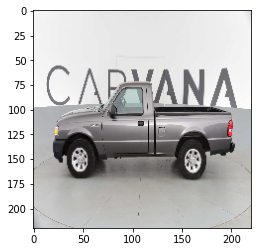

It's Mask


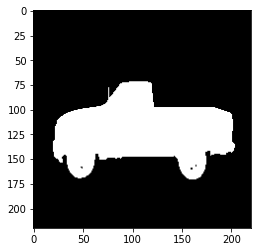

In [8]:
plt.figure(1)
print("Image")
plt.imshow(images[100], cmap= 'gray')
plt.show()
plt.figure(2)
print("It's Mask")
plt.imshow(masks[100], cmap= 'gray')
plt.show()

Checking if GPU is available

In [9]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


Transferring the Images to GPU

In [10]:
images = torch.tensor(images, device = DEVICE)
masks = torch.tensor(masks, device = DEVICE)

Normalize the image

In [11]:
images = images.float()
mean = (torch.mean(images))
images = images/ mean

Reshaping the Image for network to work on

In [12]:
#changing image dimension to that which is accepted by the the model
images = images.permute(0,3,1,2)

In [10]:
x = torch.ones(10,50,50,50, device= DEVICE)

In [11]:
x.shape

torch.Size([10, 50, 50, 50])

In [12]:
import torchvision.transforms.functional as TF
y = TF.resize(x, size=[55,52])

In [ ]:
y.shape

In [ ]:
y[0,0,54]

In [13]:
import torchvision.transforms.functional as TF

#Creating Unet Netowk architecture

##Paper: https://arxiv.org/abs/1505.04597
There is some changes as compared to orignal Unet architectures to improve the performance

In [14]:
class unet(nn.Module):

  def __init__(self, in_channels, out_channels):     #Features is the dimension of Height and Width of the image
    super(unet, self).__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

    #upsampling layers
    self.up1 = nn.ConvTranspose2d( 1024, 512, kernel_size=2, stride=2, )
    self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    
    self.up2 = nn.ConvTranspose2d( 512, 256, kernel_size=2, stride=2, )
    self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    
    self.up3 = nn.ConvTranspose2d( 256, 128, kernel_size=2, stride=2, )
    self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    
    self.up4 = nn.ConvTranspose2d( 128, 64, kernel_size=2, stride=2, )
    self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv_final = nn.Conv2d(64, out_channels, 3, 1, 1)               #output channel is the no of classes
    
  def forward(self, input):

    #Downsampling Part
    out = self.conv1(input)
    out_1 = out
    out = self.pool1(out)       #()

    out = self.conv2(out)
    out_2 = out
    out = self.pool2(out)

    out = self.conv3(out)
    out_3 = out
    out = self.pool3(out)
    
    out = self.conv4(out)
    out_4 = out
    out = self.pool4(out)
    
    out = self.conv5(out)
    
    #Upsampling part
    out = self.up1(out) 
    if out_4.shape != out.shape:
      out = TF.resize(out, size= [out_4.shape[2], out_4.shape[3]])
    out = torch.cat((out_4, out), dim = 1)
    out = self.conv6(out)

    out = self.up2(out)  
    if out_3.shape != out.shape:
      out = TF.resize(out, size= [out_3.shape[2], out_3.shape[3]]) 
    out = torch.cat((out_3, out), dim = 1)
    out = self.conv7(out)

    out = self.up3(out) 
    if out_2.shape != out.shape:
      out = TF.resize(out, size= [out_2.shape[2], out_2.shape[3]])    
    out = torch.cat((out_2, out), dim = 1)
    out = self.conv8(out)

    out = self.up4(out) 
    if out_1.shape != out.shape:
      out = TF.resize(out, size= [out_1.shape[2], out_1.shape[3]])    
    out = torch.cat((out_1, out), dim = 1)
    out = self.conv9(out)

    out = self.conv_final(out)

    return out

    #Using transpose convolutions insted of Bilinear interpolation used in orignal paper




In [15]:
model = unet(3,2).to(device = DEVICE)

In [16]:
model(images[0].reshape(1, images[0].shape[0], images[0].shape[1], images[0].shape[2])).shape

torch.Size([1, 2, 220, 220])

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        #update the weights of the model 
loss_type = torch.nn.CrossEntropyLoss()
#loss_type = nn.L1Loss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 100, gamma = 0.9)   #Every 100 epochs our learning rate will be multiplied by gamma

In [20]:
np.unique(masks[70].cpu().numpy())

array([0, 1], dtype=uint8)

In [19]:
#Model Training
CUDA_LAUNCH_BLOCKING=1
loss_graph = []
num_epochs = 1000
num_train = images.shape[0]
batch_size = 20
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = masks[random_no]

  model.train()
  optimizer.zero_grad()
  y_pred = model(x_batch)
  y_pred = y_pred.permute(0,2,3,1)
  y_pred = y_pred.reshape(-1,2)
  y_batch = y_batch.reshape(-1)
  
  loss = loss_type(y_pred, y_batch)
  loss.backward()
  optimizer.step()

  #schedular step
  #step_lr.step()

  loss_graph.append(loss.cpu().item())
  if i%10==0:
    print("Epoch: ", i+1, ", loss is: ", loss.cpu().item())
    #print("Learning rate is: ", optimizer.state_dict()['param_groups'][0]['lr'])

Epoch:  1 , loss is:  0.30907800793647766
Epoch:  11 , loss is:  0.08717972785234451
Epoch:  21 , loss is:  0.05392221361398697
Epoch:  31 , loss is:  0.04132302477955818
Epoch:  41 , loss is:  0.04611244425177574
Epoch:  51 , loss is:  0.03811280056834221
Epoch:  61 , loss is:  0.029749387875199318
Epoch:  71 , loss is:  0.04084526002407074
Epoch:  81 , loss is:  0.04249558970332146
Epoch:  91 , loss is:  0.026171527802944183
Epoch:  101 , loss is:  0.02465352788567543
Epoch:  111 , loss is:  0.03460787609219551
Epoch:  121 , loss is:  0.026784803718328476
Epoch:  131 , loss is:  0.021889900788664818
Epoch:  141 , loss is:  0.023625483736395836
Epoch:  151 , loss is:  0.023667246103286743
Epoch:  161 , loss is:  0.01959170028567314
Epoch:  171 , loss is:  0.022460956126451492
Epoch:  181 , loss is:  0.019055217504501343
Epoch:  191 , loss is:  0.017703980207443237
Epoch:  201 , loss is:  0.021112563088536263
Epoch:  211 , loss is:  0.015311106108129025
Epoch:  221 , loss is:  0.018344

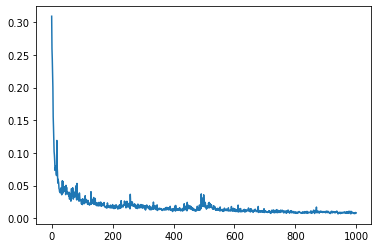

In [20]:
#Loss Graph
plt.plot(loss_graph)
plt.show()

#Final result from the Trained Model: 

Predicted segmentation mask


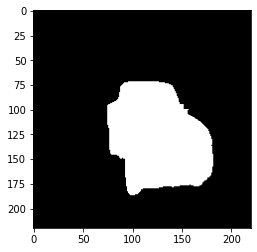

Actual mask


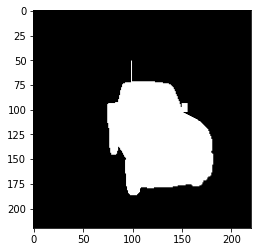

In [21]:
y = model(images[111].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(220,220)
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap= 'gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(masks[111].clone().cpu()), cmap= 'gray')
plt.show()

#Saving the weights of the trined Model:


In [25]:
save_model = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
path_save = '/content/drive/MyDrive/DL/model_unet.pth'
torch.save(save_model, path_save)
print("Model Saved ")

Model Saved 


#Loading the trained model and using it to detect masks

In [28]:
load_path = '\content\drive\MyDrive\DL\model_unet.pth'
load = torch.load(load_path)
model_load = unet(3, 2).to(device = DEVICE)
model_load.load_state_dict(load['state_dict'])

<All keys matched successfully>

Predicted segmentation mask


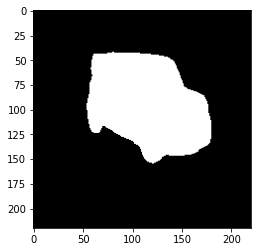

Actual mask


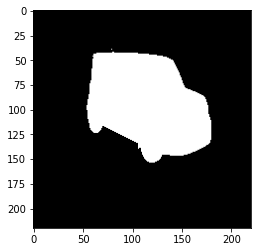

In [32]:
y = model_load(images[30].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(220,220)
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap='gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(masks[30].clone().cpu()), cmap='gray')
plt.show()

#Training the model using pytorch dataloader and other pytorch tools

In [33]:
from torch.utils.data import Dataset, DataLoader     #Importing Dataloader

In [34]:
class CustomImageDataset(Dataset):    #Making the class that takes the index and gives the images and it's corrosponding masks
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return images.shape[0]

    def __getitem__(self, idx):
        x_batch = self.images[idx]
        y_batch = self.masks[idx]
        return x_batch, y_batch

In [35]:
data = CustomImageDataset(images, masks)  #data is the object for the class that takes index and gives data and it's mask

In [36]:
batchsize = 10
dataloader = DataLoader(dataset= data, batch_size= batchsize, shuffle= True)

In [37]:
dataiter = iter(dataloader)
data = dataiter.next()
x,y = data

In [38]:
print(x.shape)
print(y.shape)

torch.Size([10, 3, 220, 220])
torch.Size([10, 220, 220])


##Training Network

In [41]:
#Model Training
loss_graph = []
num_epochs = 8   #Here each epoch means that at each epoch the model will train once over the entire datset using sgd on small batches

model.train()
for j in range(num_epochs):

  for i, (x_batch, y_batch) in enumerate(dataloader):

    optimizer.zero_grad()
    y_pred = model(x_batch)
    y_pred = y_pred.permute(0,2,3,1)
    y_pred = y_pred.reshape(-1,2)
    y_batch = y_batch.reshape(-1)
  
    loss = loss_type(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    #schedular step
    #step_lr.step()

  print("Epoch: ", j+1, ", loss is: ", loss.cpu().item())
  #print("Learning rate is: ", optimizer.state_dict()['param_groups'][0]['lr'])

Epoch:  1 , loss is:  0.023185502737760544
Epoch:  2 , loss is:  0.013393141329288483
Epoch:  3 , loss is:  0.010374952107667923
Epoch:  4 , loss is:  0.010474203154444695
Epoch:  5 , loss is:  0.01356545276939869
Epoch:  6 , loss is:  0.009080937132239342
Epoch:  7 , loss is:  0.008351595140993595
Epoch:  8 , loss is:  0.017220960929989815
